In [1]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
import os

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [3]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

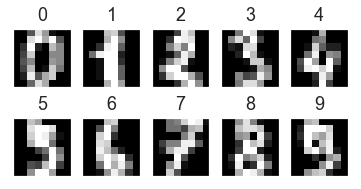

In [4]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [5]:
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [6]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [7]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(34.3329,49.2741,'0'),
  Text(-1.31973,-15.4581,'1'),
  Text(-48.6607,-17.5909,'2'),
  Text(-38.2501,19.8444,'3'),
  Text(34.0506,-39.9073,'4'),
  Text(7.20783,21.4572,'5'),
  Text(49.7836,2.49189,'6'),
  Text(-6.02751,-48.4862,'7'),
  Text(-15.6741,-1.39512,'8'),
  Text(-15.6045,33.9225,'9')])

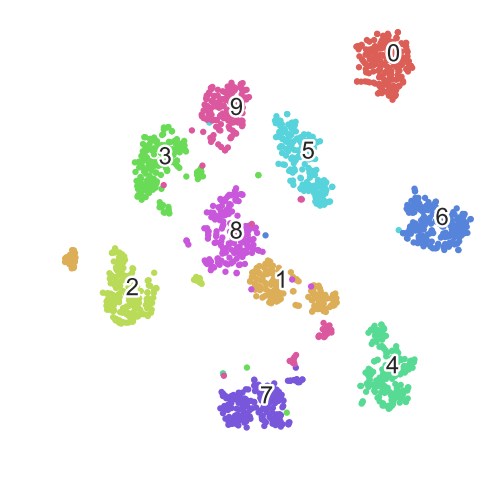

In [8]:
scatter(digits_proj, y)

In [9]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

In [10]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

In [18]:
print('X',end=' : ');print(X.shape)
print('D',end=' : ');print(D.shape)
print('P_constant',end=' : ');print(P_constant.shape)
print('P_binary',end=' : ');print(P_binary.shape)
print('P_binary_s',end=' : ');print(P_binary_s.shape)

X : (1797, 64)
D : (1797, 1797)
P_constant : (1797, 1797)
P_binary : (1613706,)
P_binary_s : (1797, 1797)


Text(0.5,1,'$p_{j|i}$ (variable $\\sigma$)')

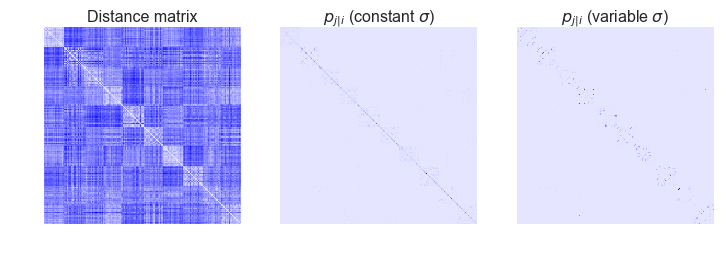

In [11]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})


In [12]:
# This list will contain the positions of the map points at every iteration.
positions = []

def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    """Batch gradient descent with momentum and individual gains.
    Parameters
    ----------
    objective : function or callable
        Should return a tuple of cost and gradient for a given parameter
        vector. When expensive to compute, the cost can optionally
        be None and can be computed every n_iter_check steps using
        the objective_error function.
    p0 : array-like, shape (n_params,)
        Initial parameter vector.
    it : int
        Current number of iterations (this function will be called more than
        once during the optimization).
    n_iter : int
        Maximum number of gradient descent iterations.
    n_iter_check : int
        Number of iterations before evaluating the global error. If the error
        is sufficiently low, we abort the optimization.
    n_iter_without_progress : int, optional (default: 300)
        Maximum number of iterations without progress before we abort the
        optimization.
    momentum : float, within (0.0, 1.0), optional (default: 0.8)
        The momentum generates a weight for previous gradients that decays
        exponentially.
    learning_rate : float, optional (default: 200.0)
        The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If
        the learning rate is too high, the data may look like a 'ball' with any
        point approximately equidistant from its nearest neighbours. If the
        learning rate is too low, most points may look compressed in a dense
        cloud with few outliers.
    min_gain : float, optional (default: 0.01)
        Minimum individual gain for each parameter.
    min_grad_norm : float, optional (default: 1e-7)
        If the gradient norm is below this threshold, the optimization will
        be aborted.
    verbose : int, optional (default: 0)
        Verbosity level.
    args : sequence
        Arguments to pass to objective function.
    kwargs : dict
        Keyword arguments to pass to objective function.
    Returns
    -------
    p : array, shape (n_params,)
        Optimum parameters.
    error : float
        Optimum.
    i : int
        Last iteration.
    """   
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1
        
        # We save the current position.
        positions.append(p.copy())
        
        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [13]:
X_proj = TSNE(random_state=RS).fit_transform(X)

In [14]:
X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

In [20]:
print('X',end=' : ');print(X.shape)
print('X_proj',end=' : ');print(X_proj.shape)
print('len(positions)',end=' : ');print(len(positions),end=' , ');print('positions[*].shape',end=' : ');print(positions[0].shape)
print('X_iter',end=' : ');print(X_iter.shape)
print('X_iter[...,-1]',end=' : ');print(X_iter[...,-1].shape)

X : (1797, 64)
X_proj : (1797, 2)
len(positions) : 1000 , positions[*].shape : (3594,)
X_iter : (1797, 2, 1000)
X_iter[...,-1] : (1797, 2)



[MoviePy] Building file C:\Users\Manor\Desktop\projectB\Oreilly\raw_mnist_tsne.gif with imageio


100%|███████████████████████████████████████████████████████████████████████████████▊| 500/501 [00:20<00:00, 24.49it/s]


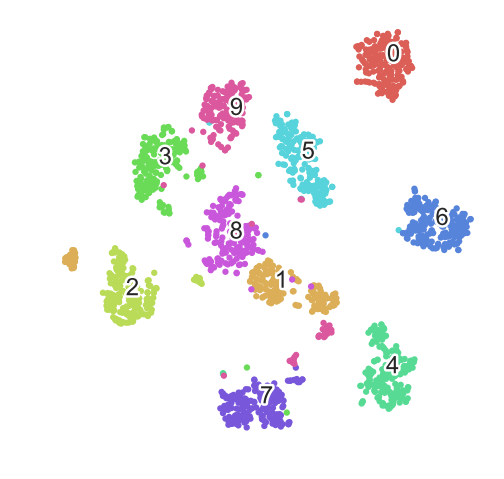

In [16]:
print()

f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif(os.path.join(os.getcwd(),'raw_mnist_tsne.gif'), fps=20)

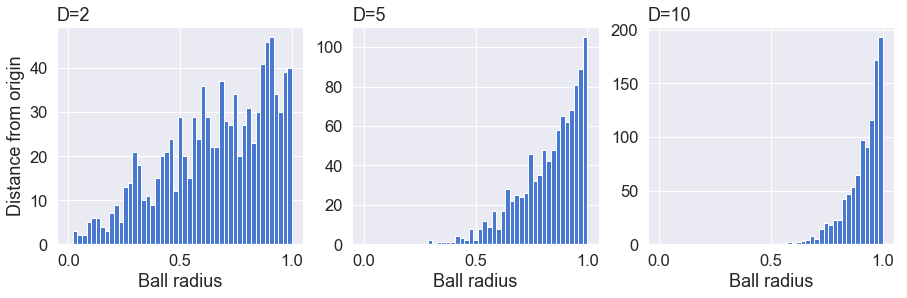

In [22]:
npoints = 1000
plt.figure(figsize=(15, 4))
for i, D in enumerate((2, 5, 10)):
    # Normally distributed points.
    u = np.random.randn(npoints, D)
    # Now on the sphere.
    u /= norm(u, axis=1)[:, None]
    # Uniform radius.
    r = np.random.rand(npoints, 1)
    # Uniformly within the ball.
    points = u * r**(1./D)
    # Plot.
    ax = plt.subplot(1, 3, i+1)
    ax.set_xlabel('Ball radius')
    if i == 0:
        ax.set_ylabel('Distance from origin')
    ax.hist(norm(points, axis=1),
            bins=np.linspace(0., 1., 50))
    ax.set_title('D=%d' % D, loc='left')

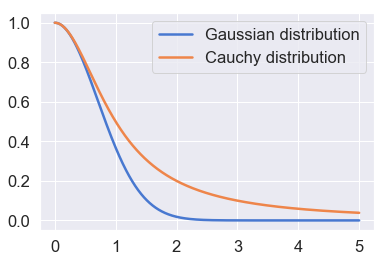

In [24]:
z = np.linspace(0., 5., 1000)
gauss = np.exp(-z**2)
cauchy = 1/(1+z**2)
plt.plot(z, gauss, label='Gaussian distribution')
plt.plot(z, cauchy, label='Cauchy distribution')
plt.legend()